In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from abc import ABC, abstractmethod
from rl import get_bandit_envs, run_bandit
from rl import PosteriorHallucinationAlg, NeuralLinearAlg, BetaBernoulliAlg, UCBAlg
from run_bandit_psar import load_bandit_rewards, get_article_ordering
from train_fns import get_model_and_optimizer_MIND as get_model_and_optimizer

In [2]:
# needs to match loaded
seed=23485223

In [3]:
model_paths = {
    'joint bb': '/shared/share_mala/implicitbayes/dataset_files/synthetic_data/bimodal/N=500,D=2500,D_eval=1000,cnts1=25,cnts2=25,forced/models//0426_bimodal_sequential_bb_ab_2/sequential:epochs=1000,bs=500,lr=0.001,wd=0.01,MLP_layers=3,MLP_width=50,weight_factor=1,max_obs=500,repeat_suffstat=1,Zdim=2,sched=constant,BB=True,alphabeta=True,seed=2340923/',
    'joint': '/shared/share_mala/implicitbayes/dataset_files/synthetic_data/bimodal/N=500,D=2500,D_eval=1000,cnts1=25,cnts2=25,forced/models//0426_bimodal_forced_sequential_2/sequential:epochs=1000,bs=500,lr=0.001,wd=0.01,MLP_layers=3,MLP_width=50,weight_factor=1,max_obs=500,repeat_suffstat=10,Zdim=2,sched=constant,seed=2340923/',
    'marginal': '/shared/share_mala/implicitbayes/dataset_files/synthetic_data/bimodal/N=500,D=2500,D_eval=1000,cnts1=25,cnts2=25,forced/models/synthetic_bimodal_flex_nn_marginal/marginal:epochs=1000,bs=500,lr=0.01,wd=0.01,MLP_layers=3,MLP_width=100,weight_factor=1,max_obs=500,Zdim=2,sched=constant,seed=2340923/'
}

In [4]:
seq_key = 'joint'
rl_dataset = 'val'

# Load predictions, models, etc

In [5]:
# LOAD MODEL PREDICTIONS ===========================================
prediction_dicts = {}
for name, run_dir in model_paths.items():
    try:
        preds = torch.load(run_dir + '/best_loss_predictions.pt')
        prediction_dicts[name] = preds
    except:
        print(f'preds: skip {name}')
    
# LOAD MODEL CHECKPOINTS ===========================================
all_model_checkpoints = {}
for model_name, model_dir in model_paths.items():
    model_path = model_dir + "/best_loss.pt"
    model_dict = torch.load(model_path, map_location=torch.device('cpu'))
    all_model_checkpoints[model_name] = model_dict
    
# LOAD MODEL EMBEDDINGS ===========================================
model_embeds = {}
for model_name, model_dir in model_paths.items():
    try:
        model_path = model_dir + "/best_loss_row_embeds.pt"
        model_dict = torch.load(model_path, map_location=torch.device('cpu'))
        model_embeds[model_name] = model_dict
    except:
        print(f'embeds: skip {name}')

# Set up bandit env

In [6]:
val_batch_size = len(prediction_dicts[seq_key][rl_dataset]['click_rates'])
article_ordering = get_article_ordering(seed, val_batch_size)

In [7]:
# Get click rates for arms in val set ===============================================
success_p_all = None
for model_name, model_dict in all_model_checkpoints.items():
    if "marg" in model_name:
        continue

    # CHECK MATCH TO ENVIRONMENT ARMS -------------------------------------
    model_saved_p_raw = model_dict[f'{rl_dataset}_loss_dict']['click_rates'].numpy()
    model_shuffled_p = model_saved_p_raw[article_ordering]
    
    if success_p_all is None:
        success_p_all = model_shuffled_p
    else:
        assert np.all( np.equal(success_p_all, model_shuffled_p) )

In [9]:
# Make bandit environments ------------------------------------
num_bandit_envs = 500
T = 1000
num_arms = 10
all_bandit_envs = get_bandit_envs(num_arms, T, num_bandit_envs, success_p_all, seed=seed)
num_imagined = 500
bandit_run_results = {}

# Load bandit algs

In [10]:
# REWARD UNDER ORACLE BANDIT ALGORITHM ========================================================
all_max_rewards = []
all_cum_rewards = []
for bandit_env, chosen_arms in all_bandit_envs:
    max_reward = np.max(bandit_env.success_p)
    assert np.all( np.equal( bandit_env.success_p, success_p_all[chosen_arms] ) )
    all_max_rewards.append( np.ones(T)*max_reward )
    all_cum_rewards.append( np.cumsum( np.ones(T)*max_reward ) )
bandit_run_results['oracle'] = np.array(all_max_rewards)

**Neural Linear**

In [11]:
from tqdm.notebook import tqdm

In [12]:
params = {
    's_squared':0.25,
    'sigma_squared':1,
}
all_rewards = []
pred_means = prediction_dicts['marginal'][rl_dataset]['theta_hats'][:,0]
for bandit_env, chosen_arms in tqdm(all_bandit_envs):
    # Instantiate bandit algorithm ------------------------------------
    bandit_alg = NeuralLinearAlg(pred_means[article_ordering][chosen_arms], num_arms, params, seed=seed)

    reward_dict = run_bandit(bandit_env, bandit_alg, T)
    all_rewards.append(reward_dict['expected_rewards'])

rewards_array = np.array(all_rewards)
bandit_run_results['GG marginal 1 0.25'] = rewards_array

  0%|          | 0/500 [00:00<?, ?it/s]

**beta bernoulli**

In [13]:
name = 'BB flat prior'
all_rewards = []
for bandit_env, chosen_arms in all_bandit_envs:
    # Instantiate bandit algorithm ------------------------------------
    bandit_alg = BetaBernoulliAlg(len(chosen_arms), {'alpha':1,'beta':1})

    reward_dict = run_bandit(bandit_env, bandit_alg, T)
    all_rewards.append(reward_dict['expected_rewards'])

rewards_array = np.array(all_rewards)
bandit_run_results[name] = rewards_array

# smaller datasets: TS-PSAR vs TS-Action

### D=100

In [14]:
def get_success_p_all(model_dir, article_ordering, rl_dataset='val'):
    model_path = model_dir + "/best_loss.pt"
    model_dict = torch.load(model_path, map_location=torch.device('cpu'))

    # CHECK MATCH TO ENVIRONMENT ARMS -------------------------------------
    model_saved_p_raw = model_dict[f'{rl_dataset}_loss_dict']['click_rates'].numpy()
    model_shuffled_p = model_saved_p_raw[article_ordering]
    
    return model_shuffled_p

In [15]:
def get_best_subdir(base_dir, return_loss=False):
    best_loss = np.inf
    best_subdir = None
    for subdir in os.listdir(base_dir):
        check = torch.load(base_dir + '/' + subdir + '/best_loss.pt', map_location='cpu')
        loss = torch.tensor(check['val_loss_dict']['loss']).item()
        if loss < best_loss:
            best_loss = loss
            best_subdir = subdir
    if return_loss:
        return best_subdir, best_loss
    return best_subdir

In [16]:
# PSAR, D=100
small_base_dir = '/shared/share_mala/implicitbayes/dataset_files/synthetic_data/bimodal_smalltest/N=500,D=100,D_eval=1000,cnts1=25,cnts2=25/models'
small_dir = small_base_dir + '/1001_psar_bimodal_test_small/'
model_dir = small_dir + get_best_subdir(small_dir)
bandit_dir = model_dir + '/bandit/num_arms=10,T=1000,num_imagined=500,seed=23485223,dataset=val,alg=sequential'

success_p_all_100 = get_success_p_all(model_dir, article_ordering)
bandit_rewards = load_bandit_rewards(bandit_dir, all_bandit_envs, success_p_all_100)
bandit_run_results['psar D=100'] = bandit_rewards['rewards']

In [17]:
# TS-Action, D=100
small_base_dir = '/shared/share_mala/implicitbayes/dataset_files/synthetic_data/bimodal_smalltest/N=500,D=100,D_eval=1000,cnts1=25,cnts2=25/models'
small_dir = small_base_dir + '/1001_dpt_bimodal_test_small/'
model_dir = small_dir + get_best_subdir(small_dir)
bandit_dir = model_dir + '/bandit/num_arms=10,T=1000,num_imagined=100,seed=23485223,dataset=val,alg=dpt/'

# use success_p_all from psar run
bandit_rewards = load_bandit_rewards(bandit_dir, all_bandit_envs, success_p_all_100)
bandit_run_results['dpt D=100'] = bandit_rewards['rewards']

### D=50

In [18]:
# PSAR, D=50
small_base_dir = '/shared/share_mala/implicitbayes/dataset_files/synthetic_data/bimodal_smalltest/N=500,D=50,D_eval=1000,cnts1=25,cnts2=25/models'
small_dir = small_base_dir + '/1001_psar_bimodal_test_small/'
model_dir = small_dir + get_best_subdir(small_dir)
bandit_dir = model_dir + '/bandit/num_arms=10,T=1000,num_imagined=500,seed=23485223,dataset=val,alg=sequential'

success_p_all_50 = get_success_p_all(model_dir, article_ordering)
bandit_rewards = load_bandit_rewards(bandit_dir, all_bandit_envs, success_p_all_50)
bandit_run_results['psar D=50'] = bandit_rewards['rewards']

In [19]:
# TS-Action, D=50
small_base_dir = '/shared/share_mala/implicitbayes/dataset_files/synthetic_data/bimodal_smalltest/N=500,D=50,D_eval=1000,cnts1=25,cnts2=25/models'
small_dir = small_base_dir + '/1001_dpt_bimodal_test_small/'
model_dir = small_dir + get_best_subdir(small_dir)
bandit_dir = model_dir + '/bandit/num_arms=10,T=1000,num_imagined=100,seed=23485223,dataset=val,alg=dpt/'

bandit_rewards = load_bandit_rewards(bandit_dir, all_bandit_envs, success_p_all_50)
bandit_run_results['dpt D=50'] = bandit_rewards['rewards']

### D=25

In [20]:
# PSAR, D=25
small_base_dir = '/shared/share_mala/implicitbayes/dataset_files/synthetic_data/bimodal_smalltest/N=500,D=25,D_eval=1000,cnts1=25,cnts2=25/models'
small_dir = small_base_dir + '/1001_psar_bimodal_test_small/'
model_dir = small_dir + get_best_subdir(small_dir)
bandit_dir = model_dir + '/bandit/num_arms=10,T=1000,num_imagined=500,seed=23485223,dataset=val,alg=sequential'

success_p_all_25 = get_success_p_all(model_dir, article_ordering)
bandit_rewards = load_bandit_rewards(bandit_dir, all_bandit_envs, success_p_all_25)
bandit_run_results['psar D=25'] = bandit_rewards['rewards']

In [21]:
# TS-Action, D=25
small_base_dir = '/shared/share_mala/implicitbayes/dataset_files/synthetic_data/bimodal_smalltest/N=500,D=25,D_eval=1000,cnts1=25,cnts2=25/models'
small_dir = small_base_dir + '/1001_dpt_bimodal_test_small/'
model_dir = small_dir + get_best_subdir(small_dir)
bandit_dir = model_dir + '/bandit/num_arms=10,T=1000,num_imagined=100,seed=23485223,dataset=val,alg=dpt/'

bandit_rewards = load_bandit_rewards(bandit_dir, all_bandit_envs, success_p_all_25)
bandit_run_results['dpt D=25'] = bandit_rewards['rewards']

### D=250

In [22]:
# PSAR, D=250
small_base_dir = '/shared/share_mala/implicitbayes/dataset_files/synthetic_data/bimodal_smalltest/N=500,D=250,D_eval=1000,cnts1=25,cnts2=25/models'
small_dir = small_base_dir + '/1001_psar_bimodal_test_small/'
model_dir = small_dir + get_best_subdir(small_dir)
bandit_dir = model_dir + '/bandit/num_arms=10,T=1000,num_imagined=500,seed=23485223,dataset=val,alg=sequential'

success_p_all_250 = get_success_p_all(model_dir, article_ordering)
bandit_rewards = load_bandit_rewards(bandit_dir, all_bandit_envs, success_p_all_250)
bandit_run_results['psar D=250'] = bandit_rewards['rewards']

In [23]:
# TS-Action, D=250
small_base_dir = '/shared/share_mala/implicitbayes/dataset_files/synthetic_data/bimodal_smalltest/N=500,D=250,D_eval=1000,cnts1=25,cnts2=25/models'
small_dir = small_base_dir + '/1001_dpt_bimodal_test_small/'
model_dir = small_dir + get_best_subdir(small_dir)
bandit_dir = model_dir + '/bandit/num_arms=10,T=1000,num_imagined=100,seed=23485223,dataset=val,alg=dpt/'

bandit_rewards = load_bandit_rewards(bandit_dir, all_bandit_envs, success_p_all_250)
bandit_run_results['dpt D=250'] = bandit_rewards['rewards']

**ts-action**

In [24]:
dpt_bandit_dir = '/shared/share_mala/implicitbayes/dataset_files/synthetic_data/bimodal/N=500,D=2500,D_eval=1000,cnts1=25,cnts2=25,forced/models/0930_dpt_bimodal_test/DPT:num_arms=10:epochs=10000,bs=5000,lr=0.001,wd=0.01,MLP_layers=3,MLP_width=100,weight_factor=1,max_obs=500,repeat_suffstat=10,Zdim=2,sched=constant,seed=2340923/bandit//num_arms=10,T=1000,num_imagined=100,seed=23485223,dataset=val,alg=dpt/'
bandit_rewards = load_bandit_rewards(dpt_bandit_dir, all_bandit_envs, success_p_all)
bandit_run_results['TS-Action'] = bandit_rewards['rewards']

**sequential**

In [25]:
num_imagined=500
bandit_dir = model_paths[seq_key] + f'/bandit/num_arms={num_arms},T={T},num_imagined={num_imagined},seed={seed},dataset={rl_dataset},alg=sequential/'
bandit_rewards = load_bandit_rewards(bandit_dir, all_bandit_envs, success_p_all)
bandit_run_results['joint'] = bandit_rewards['rewards']

**sampling variants**

In [26]:
# 1 imagined
bandit_dir = model_paths[seq_key] + f'/bandit/num_arms={num_arms},T={T},num_imagined=1,seed={seed},dataset={rl_dataset},alg=sequential/'
bandit_rewards_1 = load_bandit_rewards(bandit_dir, all_bandit_envs, success_p_all)
bandit_run_results['joint 1 generation'] = bandit_rewards_1['rewards']

In [27]:
# 1 imagined break ties
bandit_dir = model_paths[seq_key] + f'/bandit/num_arms={num_arms},T={T},num_imagined=1,seed={seed},dataset={rl_dataset},alg=sequential,rand_break_ties/'
bandit_rewards_tiebreak = load_bandit_rewards(bandit_dir, all_bandit_envs, success_p_all)
bandit_run_results['joint 1 generation break ties'] = bandit_rewards_tiebreak['rewards']

In [28]:
# sampled greedy
num_imagined=500
bandit_dir = model_paths[seq_key] + f'/bandit/num_arms={num_arms},T={T},num_imagined={num_imagined},seed={seed},dataset={rl_dataset},alg=sampled_greedy/'
bandit_rewards = load_bandit_rewards(bandit_dir, all_bandit_envs, success_p_all)
bandit_run_results['joint sampled greedy'] = bandit_rewards['rewards']

In [29]:
# greedy
num_imagined=500
bandit_dir = model_paths[seq_key] + f'/bandit/num_arms={num_arms},T={T},seed={seed},dataset={rl_dataset},alg=greedy/'
bandit_rewards = load_bandit_rewards(bandit_dir, all_bandit_envs, success_p_all)
bandit_run_results['joint greedy'] = bandit_rewards['rewards']

In [30]:
num_imagined=500
bandit_dir = model_paths['joint bb'] + f'/bandit/num_arms={num_arms},T={T},num_imagined={num_imagined},seed={seed},dataset={rl_dataset},alg=sequential/'
bandit_rewards = load_bandit_rewards(bandit_dir, all_bandit_envs, success_p_all)
bandit_run_results['joint_bb'] = bandit_rewards['rewards']

**UCB**

In [31]:
all_rewards = []
for bandit_env, chosen_arms in all_bandit_envs:
    
    # Instantiate bandit algorithm ------------------------------------
    bandit_alg = UCBAlg(num_arms=num_arms)

    reward_dict = run_bandit(bandit_env, bandit_alg, T)
    all_rewards.append(reward_dict['expected_rewards'])

rewards_array = np.array(all_rewards)
bandit_run_results['UCB'] = rewards_array

**DGP**

In [32]:
from rl import BetaBernoulliMixtureAlg

In [33]:
one_config = torch.load(model_paths[seq_key]+'/config.pt')
dataset = torch.load(one_config.data_dir + '/eval_data.pt')

all_rewards = []
for bandit_env, chosen_arms in all_bandit_envs:
    
    # Instantiate bandit algorithm ------------------------------------
    hyparam_dict = {k:v[article_ordering][chosen_arms] for k,v in dataset.items() if k in ['alpha1','alpha2','beta1','beta2']}
    hyparam_dict['mixweight']=0.5
    bandit_alg = BetaBernoulliMixtureAlg(num_arms=num_arms, hyparam_dict=hyparam_dict)

    reward_dict = run_bandit(bandit_env, bandit_alg, T)
    all_rewards.append(reward_dict['expected_rewards'])

rewards_array = np.array(all_rewards)
bandit_run_results['BB DGP'] = rewards_array

# Plot regret

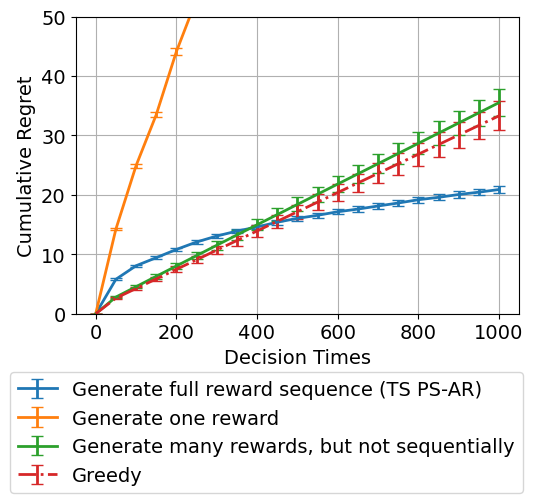

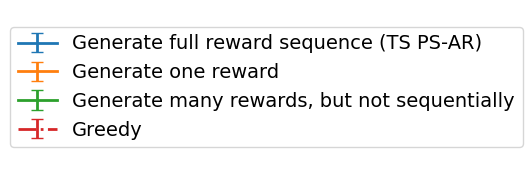

In [34]:
from collections import OrderedDict
names = OrderedDict([
            ('Generate full reward sequence (TS PS-AR)','joint'),
            ('Generate one reward','joint 1 generation break ties'),
            ('Generate many rewards, but not sequentially','joint sampled greedy'),
            ('Greedy','joint greedy'),
            ])

from util import make_plots_good
make_plots_good()
skip_val = 50

linestyle = ['-', '-', '-', '-.','-.',':', ':', ':', '-.', '-.'] 

plt.set_loglevel(level = 'warning')

maxT = 1000
cutoff_num = 21

fig, ax = plt.subplots(figsize=(5.5,4))
for k, (disp_name, key) in enumerate(names.items()):
    rewards_array = bandit_run_results[key][:,:maxT]
    regret_array = bandit_run_results['oracle'][:,:maxT] - rewards_array[:,:maxT]

    cum_regret_array = np.cumsum(regret_array, axis=1)
    cum_regret_array = np.hstack((np.zeros((len(cum_regret_array),1)), cum_regret_array))
    cum_regret = np.mean(cum_regret_array, axis=0)

    cum_regret_stderr = np.std(cum_regret_array, axis=0)  / np.sqrt(num_bandit_envs)

    
    ax.errorbar(x=np.arange(0,T+1)[::skip_val][:cutoff_num], y=cum_regret[::skip_val][:cutoff_num], 
                yerr=cum_regret_stderr[::skip_val][:cutoff_num], 
                capsize=4, linewidth=2, label=disp_name, 
                linestyle=linestyle[k])
    ax.grid(True)
ax.set_ylim([0,50])
ax.set_ylabel("Cumulative Regret", fontsize=14)
ax.set_xlabel("Decision Times", fontsize=14)
plt.tight_layout()
ax.legend(loc="center", bbox_to_anchor=(0.43, -0.4), ncol=1, fontsize=14)

label_params = ax.get_legend_handles_labels() 

figl, axl = plt.subplots(figsize=(6,2))
axl.axis(False)
axl.legend(*label_params, loc="center", bbox_to_anchor=(0.5, 0.5), ncol=1, fontsize=14)


In [35]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

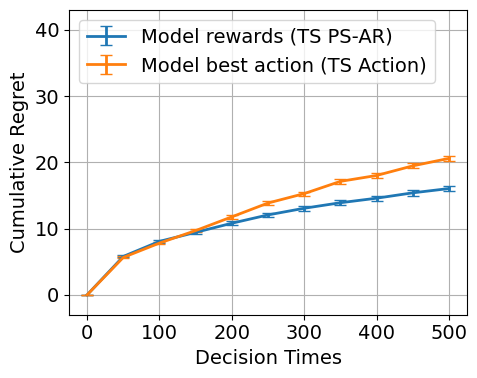

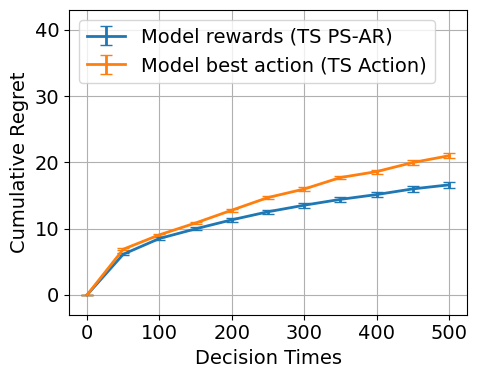

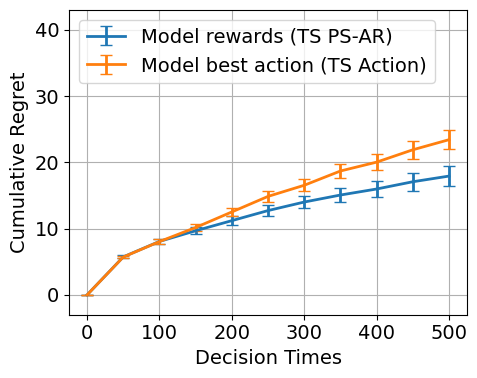

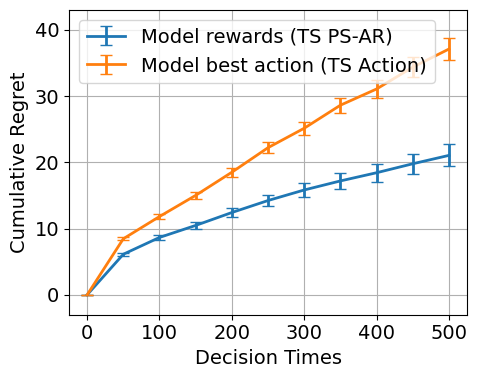

In [36]:
from collections import OrderedDict
all_names = [
    OrderedDict([
            ('Model rewards (TS PS-AR), train rows=2500','joint'),
            ('Model best action (TS Action), train rows=2500','TS-Action'),
    ]),
    OrderedDict([
            ('Model rewards (TS PS-AR), train rows=250','psar D=250'),
            ('Model best action (TS Action), train rows=250','dpt D=250'),
    ]),    
    OrderedDict([
            ('Model rewards (TS PS-AR), train rows=100','psar D=100'),
            ('Model best action (TS Action), train rows=100','dpt D=100'),
    ]),
    OrderedDict([
            ('Model rewards (TS PS-AR), train rows=25','psar D=25'),
            ('Model best action (TS Action), train rows=25','dpt D=25'),
    ]),    
]
from util import make_plots_good
make_plots_good()
skip_val = 50

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

linestyle = ['-', '-' ]#':', '-', ':','-',':']

plt.set_loglevel(level = 'warning')

for i, names in enumerate(all_names):
    fig,ax=plt.subplots(1,1,figsize=(5,4))

    for k, (disp_name, key) in enumerate(names.items()):
        rewards_array = bandit_run_results[key]
        regret_array = bandit_run_results['oracle'] - rewards_array

        cum_regret_array = np.cumsum(regret_array, axis=1)
        cum_regret_array = np.hstack((np.zeros((len(cum_regret_array),1)), cum_regret_array))
        cum_regret = np.mean(cum_regret_array, axis=0)

        cum_regret_stderr = np.std(cum_regret_array, axis=0)  / np.sqrt(num_bandit_envs)

        cutoff_num = 11
        ax.errorbar(x=np.arange(0,T+1)[::skip_val][:cutoff_num], y=cum_regret[::skip_val][:cutoff_num], 
                    yerr=cum_regret_stderr[::skip_val][:cutoff_num], 
                    capsize=4, linewidth=2, label=disp_name.split(',')[0], 
                    linestyle=linestyle[k], color=colors[k])
        ax.grid(True)
    ax.set_ylim([-3,43])
    ax.set_ylabel("Cumulative Regret")
    ax.set_xlabel("Decision Times")
    ax.legend(loc='upper left') #loc="center", bbox_to_anchor=(0.5, -0.3), ncol=1)
    plt.tight_layout()



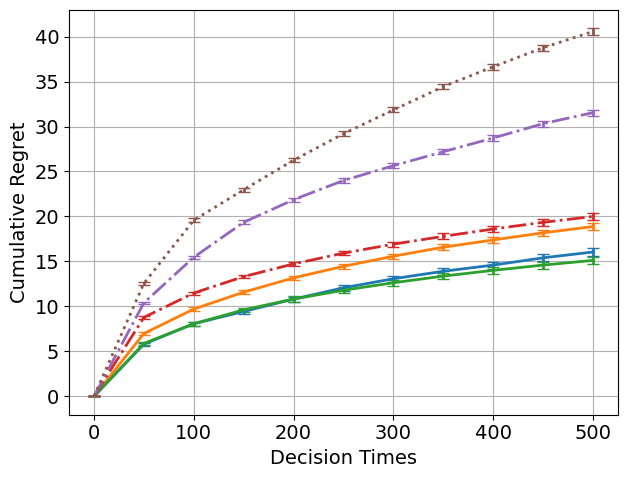

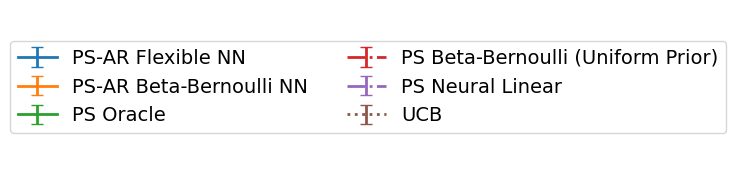

In [37]:
from collections import OrderedDict
names = OrderedDict([
            ('PS-AR Flexible NN','joint'),
            ('PS-AR Beta-Bernoulli NN','joint_bb'),
            ('PS Oracle','BB DGP'),
            ('PS Beta-Bernoulli (Uniform Prior)','BB flat prior'),
            ('PS Neural Linear', 'GG marginal 1 0.25'),
            ('UCB','UCB'),
            ])

from util import make_plots_good
make_plots_good()
skip_val = 50

linestyle = ['-', '-', '-', '-.','-.',':', ':', ':', '-.', '-.'] 

plt.set_loglevel(level = 'warning')

fig, ax = plt.subplots(figsize=(6.5,5))
for k, (disp_name, key) in enumerate(names.items()):
    rewards_array = bandit_run_results[key]
    regret_array = bandit_run_results['oracle'] - rewards_array

    cum_regret_array = np.cumsum(regret_array, axis=1)
    cum_regret_array = np.hstack((np.zeros((len(cum_regret_array),1)), cum_regret_array))
    cum_regret = np.mean(cum_regret_array, axis=0)

    cum_regret_stderr = np.std(cum_regret_array, axis=0)  / np.sqrt(num_bandit_envs)

    cutoff_num = 11
    ax.errorbar(x=np.arange(0,T+1)[::skip_val][:cutoff_num], y=cum_regret[::skip_val][:cutoff_num], 
                yerr=cum_regret_stderr[::skip_val][:cutoff_num], 
                capsize=4, linewidth=2, label=disp_name, 
                linestyle=linestyle[k])
    ax.grid(True)

ax.set_ylabel("Cumulative Regret")
ax.set_xlabel("Decision Times")
plt.tight_layout()

label_params = ax.get_legend_handles_labels() 

figl, axl = plt.subplots(figsize=(6,2))
axl.axis(False)
axl.legend(*label_params, loc="center", bbox_to_anchor=(0.5, 0.5), ncol=2)
